In [9]:
import numpy as np
import time
import math as m
import sys
import sim as vrep # access all the VREP elements
import pathcontrol as pc
import sfla
import matplotlib.pyplot as plt

In [23]:
#<---------------------------------Initialization--------------------------------------->
vrep.simxFinish(-1) # just in case, close all opened connections
clientID=vrep.simxStart('127.0.0.1',-1,True,True,5000,5) # start a connection
if clientID!=-1:
	print ('Connected to remote API server')
else:
	print('Not connected to remote API server')
	sys.exit("No connection")

# Getting handles for the motors and robot
err, motorL = vrep.simxGetObjectHandle(clientID, 'Pioneer_p3dx_leftMotor', vrep.simx_opmode_blocking)
err, motorR = vrep.simxGetObjectHandle(clientID, 'Pioneer_p3dx_rightMotor', vrep.simx_opmode_blocking)
err, robot = vrep.simxGetObjectHandle(clientID, 'Pioneer_p3dx', vrep.simx_opmode_blocking)

# Assigning handles to the ultrasonic sensors
usensor = []
for i in range(1,17):
    err, s = vrep.simxGetObjectHandle(clientID, 'Pioneer_p3dx_ultrasonicSensor'+str(i), vrep.simx_opmode_blocking)
    usensor.append(s)

# Sensor initialization
for i in range(16):
    err, state, point, detectedObj, detectedSurfNormVec = vrep.simxReadProximitySensor(
        clientID, usensor[i], vrep.simx_opmode_streaming)

Connected to remote API server


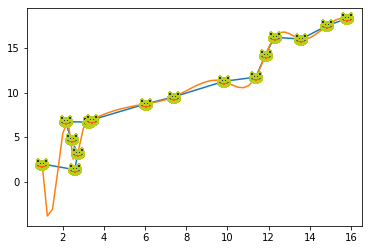

In [11]:
#<-------------------------------------SFLA------------------------------------------->
obstacles = np.load('obstacles.npy')
path_solver = sfla.sflaSolver(30, 5, 7, 12, 1)
ret, cur_pos = vrep.simxGetObjectPosition(clientID, robot, -1, vrep.simx_opmode_oneshot)
cur_pos = cur_pos[:2]
target = np.array([17,18])

path = np.empty((0,2))
pos = np.array(cur_pos)
while  np.linalg.norm(target - pos) > 0.4:
    path = np.vstack((path, pos))
    pos, frogs, memeplexes = path_solver.sfla(pos, target, obstacles)

fig, ax = plt.subplots()
ax.scatter(cur_pos[0], cur_pos[1])
ax.plot(*path.T)
pc.imgscatter(ax, 'img/frog.png', path)

pathfcn = pc.splinePath(*path.T)
pointsx = np.linspace(min(path[:,0]), max(path[:,0]), num=60, endpoint=True)
pointsy = pathfcn(pointsx)
plt.plot(pointsx, pointsy)
plt.show()

In [24]:
#<-----------------------------------Control----------------------------------------->
for step in path:
    errp = 10
    while errp > 0.2:

        avoid, ulb, urb = pc.braitenberg(clientID, usensor)
        errp, ulc, urc, pos, rot = pc.continuosControl(clientID, robot, (step[0], step[1]))
        ul = ulb if avoid else ulc
        ur = urb if avoid else urc

        errf = vrep.simxSetJointTargetVelocity(clientID, motorL, ul, vrep.simx_opmode_streaming)
        errf = vrep.simxSetJointTargetVelocity(clientID, motorR, ur, vrep.simx_opmode_streaming)


# The End
vrep.simxStopSimulation(clientID, vrep.simx_opmode_oneshot)

1